In [1]:
import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
import Solver3 as sl 
from scipy.interpolate import interp1d

%load_ext autoreload

%autoreload 2


# Generating Delta Vector

In [2]:

def cov_matrix(sigma, num_points):
  sigma = (sigma ** 2) * np.eye(num_points)
  return sigma


def compute_basis_functions_at_x(x, mesh):
    """
    Given an observation point x and the mesh, compute the two nonzero
    finite element basis (hat) functions at x.
    
    Returns:
      k: the index such that x is in [mesh[k], mesh[k+1]]
      psi_left: the value of the basis function associated with mesh[k] at x.
      psi_right: the value of the basis function associated with mesh[k+1] at x.
    """
    mesh = np.asarray(mesh, dtype=float)
    # Find the index k such that x is in [mesh[k], mesh[k+1]]
    k = np.searchsorted(mesh, x) - 1
    k = np.clip(k, 0, len(mesh) - 2)  # ensure k is valid
    
    psi_left = sl.phi_i(k, x, mesh)
    psi_right = sl.phi_i(k+1, x, mesh)
    return k, psi_left, psi_right

# Example: Evaluate the FE solution at a set of observation points
def fe_solution_at_obs(c_sol, mesh, x_obs):
    """
    Compute the finite element solution at observation points x_obs,
    given the nodal solution c_sol and the mesh.
    
    Parameters:
      c_sol : array of nodal values (length N)
      mesh  : array of node coordinates (length N)
      x_obs : array of observation points
      
    Returns:
      c_interp: array of interpolated FE solution values at x_obs.
    """
    c_sol_full = sl.assemble_nodal_values(c_sol)
    c_sol_full_array = np.asarray(c_sol_full).flatten()
    c_interp = np.zeros_like(x_obs, dtype=float)
    
    for idx, x in enumerate(x_obs):
        k, psi_left, psi_right = compute_basis_functions_at_x(x, mesh)
        # The solution at x is the weighted average of the two nodal values
        c_interp[idx] = c_sol_full_array[k] * psi_left + c_sol_full_array[k+1] * psi_right
    return c_interp

# Alternatively, if many observation points fall in the same element,
# you could vectorize the process by grouping x_obs by element.



In [3]:
def add_noise(observations_at_xi, num_points, sigma):
    """
    Adds a normally distributed noise, theta
    to observations from the forward solver.

    Arguments:
    observations_at_xi : observations at predetermined xi using interplotion. 
    num_points : how big your covariance matrix is 

    Returns:
    Delta : Array of Noisy observations.
    
    """
    sigma = cov_matrix(sigma, num_points)
    noise = np.random.multivariate_normal(np.zeros(num_points), sigma)
    delta = observations_at_xi + noise 
    return delta



# Define Likelihood Function 

In [4]:
def phi(observations, predicted, sigma) :
    '''
    For a set of predetermined points xi -- obtained via np.linspace,
    this function defines the likelihood function 

    Arguments:
    observations: Generated noisy observation using beta_true -- corresponds to y in literature
    predicted: For a proposed beta_i, we compute the noisy observation using the forward solver 
    -- corresponds to g(beta_i) in literature

    Returns: 
    Likelihood function that is proportional to the prior distribution
    
    '''
    var = sigma**2
    diff = predicted - observations
    val = 0.5 * (diff**2) / var
    return val

def assemble_nodal_values(C):
    C = np.asarray(C) # Make sure C is 1D.
    return np.concatenate(([[0.0]], C, [[0.0]]))

In [5]:
def compute_A(phi_0, phi_i, sigma):

    val = np.exp(phi_0 - phi_i)
    
    return val

def compute_integral_x_dudx(mesh, c_sol):
    c_sol_full = assemble_nodal_values(c_sol)
    total = 0.0
    for e in range(len(mesh)-1):
        x0 = mesh[e]
        x1 = mesh[e+1]
        c0 = c_sol_full[e]
        c1 = c_sol_full[e+1]
        # Slope on element e
        slope_e = (c1 - c0) / (x1 - x0)

        # Contribution from element e
        total += slope_e * (x1**2 - x0**2) * 0.5

    return total

# MCMC algorithm 

In [41]:

def MCMC_AFEM(beta_true, number_of_iter, burn_in, sigma, num_dorfler): 
  '''
  Builds a Markov Chain 

  Key Steps:
  1. Initialise a choice of Beta, beta_0 
  2. Compute likelihood of beta_0, using delta and beta_0_predicted
  3. Initialise the loop.
      - we propose a new beta_i from x* ~ Uniform(0.15, 0.85) and r ~ Uniform(0, 0.15)
      - compute y_i and g(beta_i)
      - compute likelihood using {y_i and g(beta_i)}
      - set alpha = min{1, likelihood }
  '''
  # set seed 

  # range of uniform distribution 
  x_star = 0.5
  r_range = (0.1, 0.4) 
  chain = []
  ddof_list = 0
  # compute delta 
  mesh_true , c_sol_true, ddof_true= sl.refinement_loop(beta_true, num_dorfler) 

  y_true = compute_integral_x_dudx(mesh_true, c_sol_true)
  delta = y_true + np.random.normal(0.0, sigma)

  # draw first copy of beta --> beta_0

  beta_0 = np.array([
          x_star,
          np.random.uniform(*r_range)
      ])
  print("Beta_0:", beta_0)
  
  # initialise current observations and likelihood 
  mesh_0, c_sol_0, ddof_0 = sl.refinement_loop(beta = beta_0, num_dorfler = 8)
  y_0 = compute_integral_x_dudx(mesh_0, c_sol_0)
  phi_0 = phi(delta, y_0, sigma)
  print("phi_0:", phi_0)
  
  iter_count = 0
  acceptance_count = 0 
  acceptance_prob_history = []

  for i in range(number_of_iter):
    beta_proposal = np.array([
        x_star,
        np.random.uniform(*r_range)
    ])
    print("beta proposal:", beta_proposal)
    mesh_proposal, c_sol_proposal, ddof_proposal = sl.refinement_loop(beta = beta_proposal, num_dorfler = 8)
    y_proposal = compute_integral_x_dudx(mesh_proposal, c_sol_proposal)
    phi_proposal = phi(delta, y_proposal, sigma)
    print("phi proposal:", phi_proposal)
    # compute acceptance probability 
    A = compute_A(phi_0, phi_proposal, sigma)
    acceptance_prob = min(1, A)
    acceptance_prob_history.append(acceptance_prob)
    print("acceptance probablity:", acceptance_prob)
    
    # Accept or reject the proposal
    if np.random.rand() < acceptance_prob:
      beta_0 = beta_proposal # update the current state as the last accepted proposal
      y_0 = y_proposal # update the current observations to the last accepted observation
      phi_0 = phi_proposal
      ddof_0 = ddof_proposal
      acceptance_count += 1
    
    # Record the current state.
    chain.append(beta_0.copy())
    print("Chain length:", len(chain))
    ddof_list += ddof_0
      
  avg_ddof = ddof_list/len(chain)
  chain = np.array(chain)
  # Compute the MCMC estimate as the mean of the samples after burn-in.
  beta_mcmc = np.mean(chain[burn_in:], axis=0)
  
  return chain, beta_mcmc, acceptance_count, avg_ddof


In [ ]:
def MCMC_Uniform(beta_true, number_of_iter, burn_in, sigma, num_dorfler):
    
    # Define proposal ranges:
    x_star = 0.5
    r_range = (0.1, 0.4) 
    
    # Initialize lists to store chain history and diagnostic info:
 
    chain_uniform = []
    ddof_list = []
    
    # Compute true data (delta) for both forward models:
    mesh_true , c_sol_true, ddof_true= sl.refinement_loop(beta_true, num_dorfler) 
    y_true = compute_integral_x_dudx(mesh_true, c_sol_true)
    delta = y_true + np.random.normal(0.0, sigma)
    
    uniform_mesh = np.linspace(0.0, 1.0, 600)  # 33 nodes
    # c_sol_uniform_true, fvect_true_uniform = sl.solve_scF_once(uniform_mesh, beta_true)
    # y_true_uniform = fe_solution_at_obs(c_sol_uniform_true, uniform_mesh, np.linspace(0.0, 1.0, num_points))
    # delta_uniform = add_noise(y_true_uniform, num_points, sigma)
    
    # Draw initial beta (common initial state for both chains)
    beta_0 = np.array([x_star,
                       np.random.uniform(*r_range)])
    print("Beta_0:", beta_0)
    
    
    # Initialize current state for Uniform FEM chain:
    beta_current_uniform = beta_0.copy()
    c_sol_0_uniform, fvect_0_uniform = sl.solve_scF_once(uniform_mesh, beta_current_uniform)
    y_0_uniform = compute_integral_x_dudx(uniform_mesh, c_sol_0_uniform)
    phi_current_uniform = phi(delta, y_0_uniform, sigma)
    

    acceptance_count_uniform = 0
    acceptance_prob_history_uniform = []
    
    # MCMC loop:
    for i in range(number_of_iter):
        # Generate a common proposal for β:
        beta_proposal = np.array([x_star,
                                  np.random.uniform(*r_range)])
        print("beta proposal:", beta_proposal)
        
        
        # Evaluate proposal with Uniform FEM:
        c_sol_proposal_uniform, fvect_proposal_uniform = sl.solve_scF_once(uniform_mesh, beta=beta_proposal)
        y_proposal_uniform = compute_integral_x_dudx(uniform_mesh, c_sol_proposal_uniform)
        phi_proposal_uniform = phi(delta, y_proposal_uniform, sigma)
        print("phi proposal (Uniform FEM):", phi_proposal_uniform)
        A_uniform = compute_A(phi_current_uniform, phi_proposal_uniform, sigma)
        acceptance_prob_uniform = min(1, A_uniform)
        acceptance_prob_history_uniform.append(acceptance_prob_uniform)
        print("acceptance probability (Uniform FEM):", acceptance_prob_uniform)
        
        # For Uniform FEM chain, use another independent random draw:
        if np.random.rand() < acceptance_prob_uniform:
            beta_current_uniform = beta_proposal.copy()
            y_current_uniform = y_proposal_uniform.copy()
            phi_current_uniform = phi_proposal_uniform
            acceptance_count_uniform += 1
        
        # Record the current states in their respective chains:
        chain_uniform.append(beta_current_uniform.copy())
        print("Uniform =", len(chain_uniform))
    

    chain_uniform = np.array(chain_uniform)
    beta_mcmc_uniform = np.mean(chain_uniform[burn_in:], axis=0)
    
    return (chain_uniform, beta_mcmc_uniform, acceptance_prob_history_uniform, acceptance_count_uniform)


In [42]:
number_of_iter = 10000
burn_in = 5000
sigma = 0.01
num_dorfler = 30
beta_true = np.array([0.5, 0.3])
np.random.seed(72)

chain_afem, beta_mcmc_afem, acceptance_count_afem, avg_dof_afem = MCMC_AFEM(beta_true, number_of_iter, burn_in, sigma, num_dorfler)
print("True beta:", beta_true )
print("MCMC estimated beta:", beta_mcmc_afem)
print("Acceptance Count:", acceptance_count_afem)
print("ddof list:", avg_dof_afem)



length mesh: 5
Beta_0: [0.5        0.26048879]
length mesh: 5
phi_0: [0.17069926]
beta proposal: [0.5        0.21075612]
length mesh: 5
phi proposal: [0.38461658]
acceptance probablity: [0.80741514]
Chain length: 1
beta proposal: [0.5        0.27635424]
length mesh: 5
phi proposal: [0.11723277]
acceptance probablity: 1
Chain length: 2
beta proposal: [0.5        0.15200021]
length mesh: 5
phi proposal: [0.58495281]
acceptance probablity: [0.62642888]
Chain length: 3
beta proposal: [0.5        0.25020366]
length mesh: 5
phi proposal: [0.22932421]
acceptance probablity: 1
Chain length: 4
beta proposal: [0.5        0.38400278]
length mesh: 5
phi proposal: [0.27574755]
acceptance probablity: [0.95463775]
Chain length: 5
beta proposal: [0.5        0.17424091]
length mesh: 5
phi proposal: [0.51124367]
acceptance probablity: [0.79017873]
Chain length: 6
beta proposal: [0.5        0.29027773]
length mesh: 5
phi proposal: [0.06280975]
acceptance probablity: 1
Chain length: 7
beta proposal: [0.5 

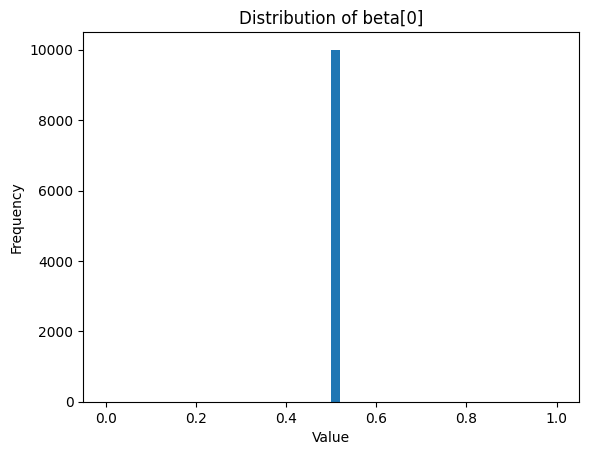

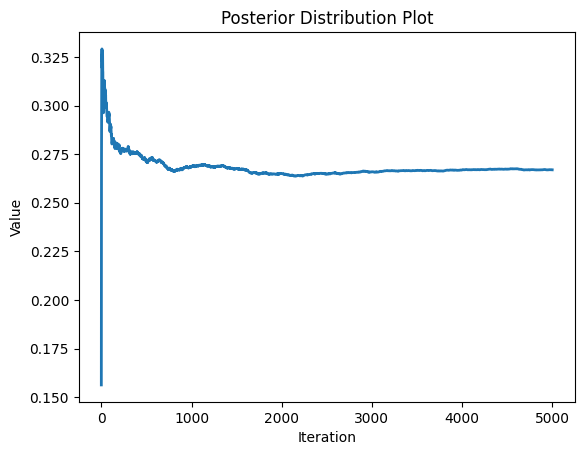

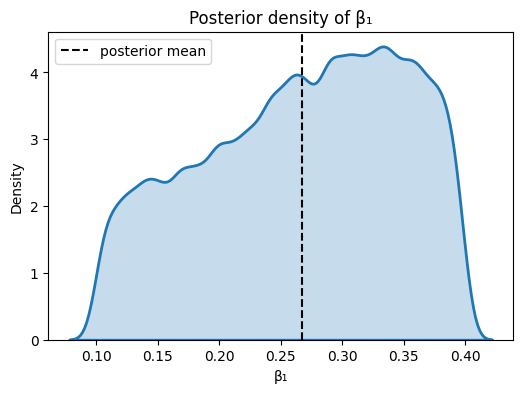

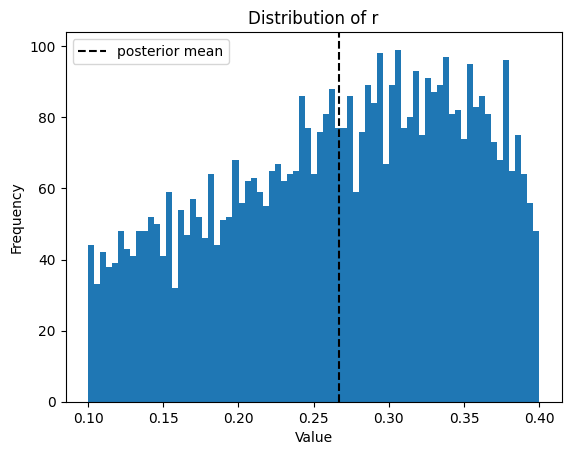

In [47]:
plt.hist(chain_afem[:, 0], bins=50)
plt.title("Distribution of beta[0]")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

import seaborn as sns

chain_burned = chain_afem[5000:, :]

num_samples = len(chain_burned)  # or chain.shape[0]

# Create the iteration index
iterations = np.arange(num_samples)


# Repeat for beta[1] if you like
beta = chain_burned[:, 1]                     # column 1 = β[1]
running_mean = np.cumsum(beta) / np.arange(1, len(beta)+1)

window = 100
rolling_med = pd.Series(beta).rolling(window).median()

fig, ax = plt.subplots()
#ax.scatter(range(len(beta)), beta, s=6, alpha=0.4)
ax.plot(running_mean, linewidth=2)     # centre line
ax.set(xlabel='Iteration', ylabel='Value',
       title='Posterior Distribution Plot')
plt.show()

plt.figure(figsize=(6, 4))
sns.kdeplot(chain_burned[:, 1], fill=True, linewidth=2, bw_adjust=0.5)   # fill=True shades under the curve
plt.axvline(chain_burned[:, 1].mean(), color='k', ls='--', label='posterior mean')
plt.title("Posterior density of β₁")
plt.xlabel("β₁")
plt.legend()
plt.show()


plt.hist(chain_burned[:, 1], bins=75)
plt.axvline(chain_burned[:, 1].mean(), color='k', ls='--', label='posterior mean')
plt.title("Distribution of r")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
def MCMC(beta_true, number_of_iter, burn_in, sigma, num_dorfler):
    '''
    Builds two MCMC chains (one using AFEM and one using a uniform mesh) using the same sequence of proposed β.
    
    Parameters:
      beta_true      : The true parameter used to generate the true data.
      number_of_iter : Total number of MCMC iterations.
      burn_in        : Number of iterations to discard as burn-in.
      sigma          : Noise standard deviation.
      num_points     : Number of observation points.
    
    Returns:
      chain_afem, beta_mcmc_afem, acceptance_prob_history_afem, acceptance_count_afem,
      chain_uniform, beta_mcmc_uniform, acceptance_prob_history_uniform, acceptance_count_uniform,
      ddof_list
    '''

    
    # Define proposal ranges:
    x_star = 0.5
    r_range = (0.1, 0.4) 
    
    # Initialize lists to store chain history and diagnostic info:
    chain_afem = []
    chain_uniform = []
    ddof_list = []
    
    # Compute true data (delta) for both forward models:
    mesh_true , c_sol_true, ddof_true= sl.refinement_loop(beta_true, num_dorfler) 
    y_true = compute_integral_x_dudx(mesh_true, c_sol_true)
    delta = y_true + np.random.normal(0.0, sigma)
    
    uniform_mesh = np.linspace(0.0, 1.0, 635)  # 33 nodes
    # c_sol_uniform_true, fvect_true_uniform = sl.solve_scF_once(uniform_mesh, beta_true)
    # y_true_uniform = fe_solution_at_obs(c_sol_uniform_true, uniform_mesh, np.linspace(0.0, 1.0, num_points))
    # delta_uniform = add_noise(y_true_uniform, num_points, sigma)
    
    # Draw initial beta (common initial state for both chains)
    beta_0 = np.array([x_star,
                       np.random.uniform(*r_range)])
    print("Beta_0:", beta_0)
    
    # Initialize current state for AFEM chain:
    beta_current_afem = beta_0.copy()
    mesh_0_afem, c_sol_0_afem, ddof_0_afem = sl.refinement_loop(beta = beta_current_afem, num_dorfler = 15)
    y_current_afem = compute_integral_x_dudx(mesh_0_afem, c_sol_0_afem)
    phi_current_afem = phi(delta, y_current_afem, sigma)
    print("phi_0:", phi_current_afem)
    print("ddof cuurent:", ddof_0_afem)
    
    # Initialize current state for Uniform FEM chain:
    beta_current_uniform = beta_0.copy()
    c_sol_0_uniform, fvect_0_uniform = sl.solve_scF_once(uniform_mesh, beta_current_uniform)
    y_current_uniform = compute_integral_x_dudx(uniform_mesh, c_sol_0_uniform)
    phi_current_uniform = phi(delta, y_current_uniform , sigma)
    
    acceptance_count_afem = 0
    acceptance_count_uniform = 0
    acceptance_prob_history_afem = []
    acceptance_prob_history_uniform = []
    
    # MCMC loop:
    for i in range(number_of_iter):
        # Generate a common proposal for β:
        beta_proposal = np.array([x_star,
                                  np.random.uniform(*r_range)])
        print("beta proposal:", beta_proposal)
        
        # Evaluate proposal with AFEM:
        mesh_proposal_afem, c_sol_proposal_afem, ddof_proposal_afem = sl.refinement_loop(beta = beta_proposal, num_dorfler = 15)
        print("ddof proposal:", ddof_proposal_afem)
        y_proposal_afem = compute_integral_x_dudx(mesh_proposal_afem, c_sol_proposal_afem)
        ddof_list.append((beta_proposal, ddof_proposal_afem))
        phi_proposal_afem = phi(delta, y_proposal_afem, sigma)
        print("phi proposal (AFEM):", phi_proposal_afem)
        A_afem = compute_A(phi_current_afem, phi_proposal_afem, sigma)
        acceptance_prob_afem = min(1, A_afem)
        acceptance_prob_history_afem.append(acceptance_prob_afem)
        print("acceptance probability (AFEM):", acceptance_prob_afem)
        
        # Evaluate proposal with Uniform FEM:
        c_sol_proposal_uniform, fvect_proposal_uniform = sl.solve_scF_once(uniform_mesh, beta=beta_proposal)
        y_proposal_uniform = compute_integral_x_dudx(uniform_mesh, c_sol_proposal_uniform)
        phi_proposal_uniform = phi(delta, y_proposal_uniform, sigma)
        print("phi proposal (Uniform FEM):", phi_proposal_uniform)
        A_uniform = compute_A(phi_current_uniform, phi_proposal_uniform, sigma)
        acceptance_prob_uniform = min(1, A_uniform)
        acceptance_prob_history_uniform.append(acceptance_prob_uniform)
        print("acceptance probability (Uniform FEM):", acceptance_prob_uniform)
        
        # For AFEM chain, use an independent random draw:
        if np.random.rand() < acceptance_prob_afem:
            beta_current_afem = beta_proposal.copy()
            y_current_afem = y_proposal_afem.copy()
            phi_current_afem = phi_proposal_afem
            acceptance_count_afem += 1
        
        # For Uniform FEM chain, use another independent random draw:
        if np.random.rand() < acceptance_prob_uniform:
            beta_current_uniform = beta_proposal.copy()
            y_current_uniform = y_proposal_uniform.copy()
            phi_current_uniform = phi_proposal_uniform
            acceptance_count_uniform += 1
        
        # Record the current states in their respective chains:
        chain_afem.append(beta_current_afem.copy())
        chain_uniform.append(beta_current_uniform.copy())
        print("Chain lengths: AFEM =", len(chain_afem), ", Uniform =", len(chain_uniform))
    
    chain_afem = np.array(chain_afem)
    chain_uniform = np.array(chain_uniform)
    beta_mcmc_afem = np.mean(chain_afem[burn_in:], axis=0)
    beta_mcmc_uniform = np.mean(chain_uniform[burn_in:], axis=0)
    
    return (chain_afem, beta_mcmc_afem, acceptance_prob_history_afem, acceptance_count_afem,
            chain_uniform, beta_mcmc_uniform, acceptance_prob_history_uniform, acceptance_count_uniform,
            ddof_list)


In [10]:

number_of_iter = 10000
burn_in = 5000
sigma = 0.01
num_dorfler = 30
beta_true = np.array([0.5, 0.3])

# Call the MCMC function (assuming it has been defined and imported as above)
(chain_afem, beta_mcmc_afem, acceptance_prob_history_afem, acceptance_count_afem,
 chain_uniform, beta_mcmc_uniform, acceptance_prob_history_uniform, acceptance_count_uniform,
 ddof_list) = MCMC(beta_true, number_of_iter, burn_in, sigma, num_dorfler)

# Print the results
print("True beta:", beta_true)
print("AFEM recovered beta (mean after burn-in):", beta_mcmc_afem)
print("Uniform FEM recovered beta (mean after burn-in):", beta_mcmc_uniform)
print("AFEM acceptance count:", acceptance_count_afem)
print("Uniform FEM acceptance count:", acceptance_count_uniform)
print("AFEM acceptance probability history (first 10 samples):", acceptance_prob_history_afem[:10])
print("Uniform FEM acceptance probability history (first 10 samples):", acceptance_prob_history_uniform[:10])


length mesh: 5
Beta_0: [0.5        0.26048879]
length mesh: 5
phi_0: [0.19698009]
ddof cuurent: 577
beta proposal: [0.5        0.21075612]
length mesh: 5
ddof proposal: 641
phi proposal (AFEM): [0.40990702]
acceptance probability (AFEM): [0.80821519]
phi proposal (Uniform FEM): [0.40992372]
acceptance probability (Uniform FEM): [0.80845215]
Chain lengths: AFEM = 1 , Uniform = 1
beta proposal: [0.5        0.31482214]
length mesh: 5
ddof proposal: 619
phi proposal (AFEM): [0.01539728]
acceptance probability (AFEM): 1
phi proposal (Uniform FEM): [0.01549925]
acceptance probability (Uniform FEM): 1
Chain lengths: AFEM = 2 , Uniform = 2
beta proposal: [0.5        0.25020366]
length mesh: 5
ddof proposal: 558
phi proposal (AFEM): [0.24121072]
acceptance probability (AFEM): [0.79786694]
phi proposal (Uniform FEM): [0.24151139]
acceptance probability (Uniform FEM): [0.79770842]
Chain lengths: AFEM = 3 , Uniform = 3
beta proposal: [0.5        0.22487796]
length mesh: 5
ddof proposal: 683
phi pr